# Imports and loads

In [1]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores.csv', encoding='utf-8')
print(df05ht.shape)

(241789, 27)


In [2]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'passes_home', 'passes_away',
       'fouls_c_home', 'fouls_c_away', 'fouls_won_home', 'fouls_won_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id'],
      dtype='object')

In [3]:
# pd.set_option('display.max_rows', None)
# display(df05ht[(df05ht['homeTeam'] == 'Grêmio Novorizontino') & (df05ht['awayTeam'] == 'Vancouver Whitecaps FC')])

# Preprocessamento dos dados

In [4]:
df = df05ht.copy()
# Atualizando a coluna 'result' para 0, exceto onde já é 1
# df.loc[df['result'] != 1, 'result'] = 0

# # Removendo duplicatas com base em 'match_id' e 'minute'
# df.drop_duplicates(subset=['match_id', 'minute'], keep='last', inplace=True)

# # Classificando o DataFrame
# df.sort_values(by=['match_id', 'minute'], inplace=True)
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)

# df.to_csv('data_live_scores.csv', index=False, encoding='utf-8')

## Tratando as minutagens

In [5]:
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')

# Convertendo os minutos para inteiros
df['minute_converted'] = df05ht['minute'].str.extract('(\d+)').astype(int)

# Removendo os minutos iguais a 0
df = df[df['minute_converted'] != 0]

# Identificando e removendo IDs de jogos com minutos fora do intervalo permitido
invalid_ids = df[df['minute_converted'] > 45]['match_id'].unique()
df = df[~df['match_id'].isin(invalid_ids)]


# Removendo a coluna 'minute_converted' e salvando o DataFrame com o formato original (sem os minutos convertidos)

df.drop_duplicates(keep='last', inplace=True)
df.drop(columns=['minute_converted']).to_csv('data_teste.csv', index=False, encoding='utf-8')


df['minute'] = df['minute_converted']
df.drop(columns=['minute_converted'], inplace=True)
df.drop_duplicates(keep='last', inplace=True)

print(f'Valores únicos de minutos após a conversão: {df.minute.unique()} \n')

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Registros retirados: {df05ht.shape[0] - df.shape[0]}')
print(f'Jogos que serão retirados: {len(invalid_ids)}')

Dimensão do DataFrame antes remoção: (241789, 27)
Valores únicos de minutos antes da conversão: ['0:32' '10:26' '11:06' ... '90+41:44' '20:44' '17:15'] 

Valores únicos de minutos após a conversão: [10 11 12 13 14 15 16 17 18 19  1 20 21 22 23 24 25 26 27 28 29  2 30 31
 32 33 34 35 36 37 38 39  3 40 41 42 43 44 45  4  5  6  7  8  9] 

Dimensão do DataFrame após remoção: (224129, 27)
Registros retirados: 17660
Jogos que serão retirados: 8


In [6]:
# datas com minutos inválidos
print(f"Datas a verificar: {df05ht[df05ht['match_id'].isin(invalid_ids)]['date'].unique()}")

Datas a verificar: ['2020-03-14' '2022-08-23' '2022-11-14' '2022-12-04' '2023-06-13'
 '2023-07-12' '2020-03-05' '2020-07-23']


## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

In [7]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = (df['passes_away'] / total_passes) * 100
df['possessiontime_home'] = (df['passes_home'] / total_passes) * 100
print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away']
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.dropna(inplace=True)
print("\nDataFrame após remover valores NA:\n", df.info())

df.drop_duplicates(subset=['match_id', 'minute'], keep='last', inplace=True)
print("\nDataFrame após remover duplicatas:\n", df.info())

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')


Ligas únicas: ['South America - CONMEBOL Libertadores' 'Brazil - Paulista A1'
 'Asia - AFC Champions League' 'Brazil - Supercopa do Brasil'
 'Japan - J1 League' 'South America - CONMEBOL Sudamericana' 'USA - MLS'
 'Brazil - Copa do Brasil' 'Germany - Play-offs 1/2' 'Mexico - Liga MX'
 'Scotland - Premiership' 'Brazil - Serie A' 'France - Ligue 1'
 'Europe - UEFA Champions League' 'England - League Cup'
 'Europe - UEFA Nations League' 'England - Premier League'
 'Germany - Bundesliga' 'Italy - Serie A' 'Italy - Serie B'
 'Netherlands - Eredivisie' 'England - Championship'
 'Spain - Primera División' 'Greece - Super League 1'
 'South America - CONMEBOL World Cup Qualifiers' 'England - League One'
 'England - League Two' 'Europe - UEFA Europa League'
 'Argentina - Liga Profesional Argentina' 'England - FA Cup'
 'Australia - A-League Men' 'Europe - UEFA European Championship'
 'N/C America - Concacaf Gold Cup' 'Europe - UEFA World Cup Qualifiers'
 'Denmark - Superliga' 'Saudi Arabia - Saud

## Tratando o formato das ligas para ligas existentes na API

In [8]:
# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Romania - Supercupa': 'Romania - Super Cup',
    'Romania - Play-offs 1/2': 'Romania - Liga 1 - Play-offs',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', #* grupos f,j...
    'South America - CONMEBOL Sudamericana': 'South America - CONMEBOL Sudamericana', # nao tem
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'South America - CONMEBOL World Cup Qualifiers', # nao tem
    'Europe - UEFA World Cup Qualifiers': 'Europe - UEFA World Cup Qualifiers', # nao tem
    "Europe - UEFA Women's Championship": 'Europe - UEFA Women Championship', # nao tem
    "France - Trophée des Champions": 'France - Trophée des Champions',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',


}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())

Liga atual: South America - CONMEBOL Libertadores
Liga atual: Brazil - Paulista A1
Liga atual: Asia - AFC Champions League
Liga atual: Brazil - Supercopa do Brasil
Liga atual: Japan - J1 League
Liga atual: South America - CONMEBOL Sudamericana
Liga atual: USA - MLS
Liga atual: Brazil - Copa do Brasil
Liga atual: Germany - Play-offs 1/2
Liga atual: Mexico - Liga MX
Liga atual: Scotland - Premiership
Liga atual: Brazil - Serie A
Liga atual: France - Ligue 1
Liga atual: Europe - UEFA Champions League
Liga atual: England - League Cup
Liga atual: Europe - UEFA Nations League
Liga atual: England - Premier League
Liga atual: Germany - Bundesliga
Liga atual: Italy - Serie A
Liga atual: Italy - Serie B
Liga atual: Netherlands - Eredivisie
Liga atual: England - Championship
Liga atual: Spain - Primera División
Liga atual: Greece - Super League 1
Liga atual: South America - CONMEBOL World Cup Qualifiers
Liga atual: England - League One
Liga atual: England - League Two
Liga atual: Europe - UEFA Eu

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de partidas por time: 914

Filtrando dados de ligas...
Ligas com um único valor de resultado: ['England - Community Shield', 'Europe - Uefa Super Cup', 'Germany - Bundesliga Play-offs', 'Italy - Super Cup', 'N/C America - Leagues Cup', 'South America - Recopa Sudamericana']
Ligas com menos de 100 partidas: ['Spain - Super Cup', 'World - FIFA Club World Cup', 'South America - Recopa Sudamericana', 'England - Community Shield', 'Portugal - Primeira Liga - Play-offs', 'Brazil - Supercopa do Brasil', 'Europe - Uefa Super Cup', 'Italy - Super Cup', 'Germany - Bundesliga Play-offs', 'N/C America - Leagues Cup']
Ligas para excluir: ['England - Community Shield', 'Europe - Uefa Super Cup', 'Germany - Bundesliga Play-offs', 'Italy - Super Cup', 'N/C America - Leagues Cup', 'South America - Recopa Sudamericana', 'Spain - Super Cup', 'World - FIFA Club World Cup', 'South America - Recopa Sudamericana', 'England - Community Shield', 'Portugal - Primeira Liga - P

,minute,homeTeam,awayTeam,league,corners_home,corners_away,redcards_home,redcards_away,shotsOffgoal_home,shotsOffgoal_away,...,fouls_home,fouls_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id,possessiontime_away,possessiontime_home
0,42,Club Cerro Porteño,Club Universitario de Deportes,South America - Copa Libertadores,4.0,2.0,0.0,0.0,4.0,2.0,...,6.0,4.0,2.0,2.0,4.0,4.0,0.0,2020-02-12-Club Cerro Porteño-Club Universitar...,40.425532,59.574468
1,22,CR Flamengo,Racing Club,South America - Copa Libertadores,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,4.0,1.0,0.0,4.0,3.0,0.0,2023-06-09-CR Flamengo-Racing Club,37.969925,62.030075
2,9,AC Lara,Santos FC Sao Paulo,South America - Copa Libertadores,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,0.0,0.0,2.0,2.0,0.0,2021-03-16-AC Lara-Santos FC Sao Paulo,79.844961,20.155039



Analisando e visualizando os dados...

Distribuição de resultados:
 0.0    0.5
1.0    0.5
Name: result, dtype: float64


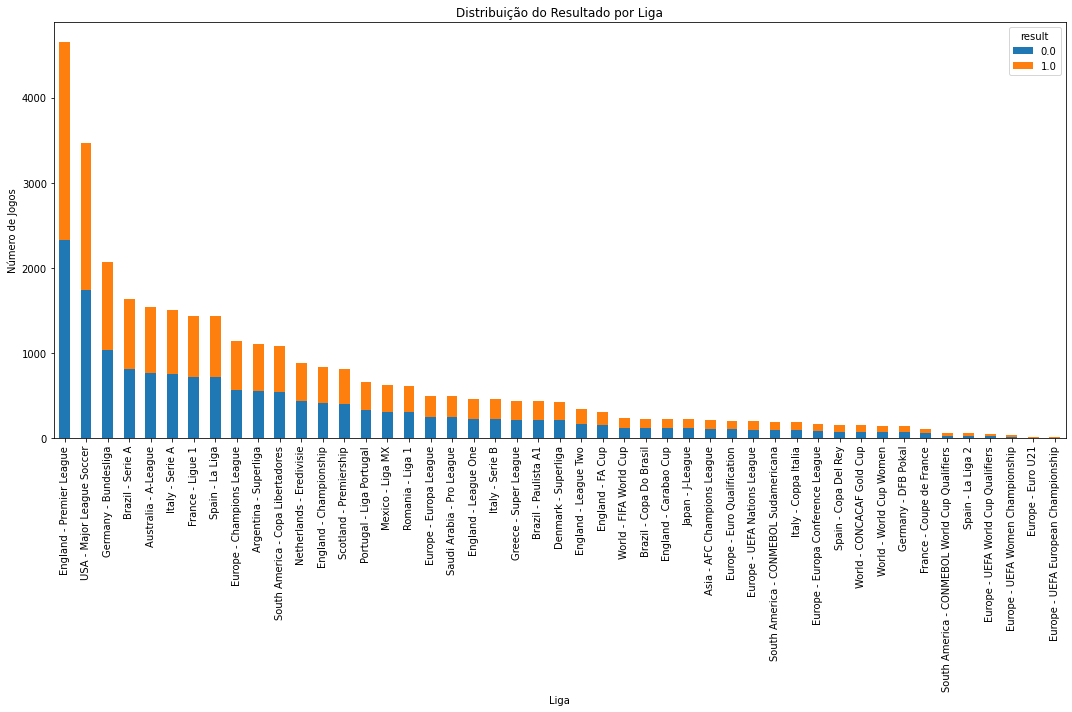

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def count_matches(df, home_col, away_col):
    """Conta as partidas jogadas por cada time, tanto em casa quanto fora."""
    matches_home = df[home_col].value_counts()
    matches_away = df[away_col].value_counts()
    return matches_home.add(matches_away, fill_value=0)

def filter_leagues(df, league_col, result_col, min_matches=100):
    """Filtra ligas com base no número de partidas e na diversidade de resultados."""
    # Identifica ligas com um único valor de resultado
    single_value_leagues = df.groupby(league_col).apply(lambda x: len(x[result_col].unique()) == 1)
    print("Ligas com um único valor de resultado:", single_value_leagues[single_value_leagues].index.tolist())
    
    # Identifica ligas com menos de min_matches
    few_matches_leagues = df[league_col].value_counts()
    few_matches_leagues = few_matches_leagues[few_matches_leagues < min_matches].index.tolist()
    print("Ligas com menos de {} partidas:".format(min_matches), few_matches_leagues)
    
    # Combina as listas de ligas para exclusão
    leagues_to_drop = single_value_leagues[single_value_leagues].index.tolist() + few_matches_leagues
    print("Ligas para excluir:", leagues_to_drop)
    return df[~df[league_col].isin(leagues_to_drop)]

def balance_data(df, group_col, balance_col):
    """Balanceia os dados com base em uma coluna de agrupamento e uma coluna de balanço."""
    balanced_data = []
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        min_count = group_data[balance_col].value_counts().min()
        balanced_samples = [group_data[group_data[balance_col] == val].sample(min_count, random_state=42) for val in group_data[balance_col].unique()]
        balanced_data.extend(balanced_samples)
    return pd.concat(balanced_data, ignore_index=True)

# Aplicando as funções ao DataFrame original
print("Contando partidas por time...")
total_matches_per_team = count_matches(df, 'homeTeam', 'awayTeam')
print("Total de partidas por time:", len(total_matches_per_team))

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'result')

print("\nBalanceando dados...")
balanced_data = balance_data(filtered_data, 'league', 'result')
balanced_data.dropna(inplace=True)
df = balanced_data
print("Dados balanceados:\n")
display(balanced_data.head(3))

# Análise e visualização dos dados
print("\nAnalisando e visualizando os dados...")
result_distribution = df['result'].value_counts(normalize=True)
print("\nDistribuição de resultados:\n", result_distribution)

league_distribution = df.groupby(['league', 'result']).size().unstack().fillna(0)
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

plt.figure(figsize=(15, 10))
league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()


## Separação de Características, Transformação e Divisão de Dados

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    print("Dados separados em características (X) e variável alvo (y).")
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    
    print("Preprocessador criado com transformações para características numéricas e categóricas.")
    return preprocessor.fit(X)

# Preparando os dados
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)
print("Preprocessador ajustado aos dados.")

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor.pickle'.")

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
print("Dados transformados pelo preprocessador.")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
print("Dados divididos em conjuntos de treino e teste.")


Dados separados em características (X) e variável alvo (y).
Preprocessador criado com transformações para características numéricas e categóricas.
Preprocessador ajustado aos dados.
Preprocessador salvo em '../models/preprocessor.pickle'.
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.


# Modelos

## H2O AutoML: De Conversão de Dados a Treinamento, Carregamento e Salvamento de Modelos

In [92]:
import h2o
from h2o.automl import H2OAutoML

def initialize_h2o():
    # Inicializar o H2O
    h2o.init()
    print("H2O inicializado com sucesso.")

def convert_to_h2oframe(X, y, column_prefix="col_"):
    # Convertendo dados do NumPy/Pandas para H2OFrame
    print("Convertendo dados para H2OFrame...")
    X_h2o = h2o.H2OFrame(pd.DataFrame(X, columns=[column_prefix + str(i) for i in range(X.shape[1])]))
    y_df = y.to_frame(name="result")
    y_h2o = h2o.H2OFrame(y_df)
    y_h2o['result'] = y_h2o['result'].asfactor()
    print("Conversão concluída.")
    return X_h2o, y_h2o

def automl_training(X_train, y_train):
    # Combinando dados de treino
    print("Combinando dados de treino...")
    train_data = X_train.cbind(y_train)

    # Identificar preditores e resposta
    x = train_data.columns
    y = "result"
    x.remove(y)

    # Executar AutoML
    print("Iniciando treinamento AutoML...")
    aml = H2OAutoML(max_models=20, seed=42)
    aml.train(x=x, y=y, training_frame=train_data)
    print("Treinamento AutoML concluído.")
    return aml

initialize_h2o()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Pichau\AppData\Local\Temp\tmp7n_87jz5
  JVM stdout: C:\Users\Pichau\AppData\Local\Temp\tmp7n_87jz5\h2o_Pichau_started_from_python.out
  JVM stderr: C:\Users\Pichau\AppData\Local\Temp\tmp7n_87jz5\h2o_Pichau_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 27 days
H2O_cluster_name:,H2O_from_python_Pichau_f2vrci
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.965 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


H2O inicializado com sucesso.


In [26]:
# Conversão para H2OFrame
X_train_h2o, y_train_h2o = convert_to_h2oframe(X_train, y_train)
X_test_h2o, y_test_h2o = convert_to_h2oframe(X_test, y_test)

print("Formas dos conjuntos de dados H2O:")
print("X_train_h2o shape:", X_train_h2o.shape)
print("y_train_h2o shape:", y_train_h2o.shape)
print("X_test_h2o shape:", X_test_h2o.shape)
print("y_test_h2o shape:", y_test_h2o.shape)

# Treinamento com AutoML
aml = automl_training(X_train_h2o, y_train_h2o)

# Visualizar leaderboard
print("Leaderboard do AutoML:")
print(aml.leaderboard)

# Obter o melhor modelo
best_model = aml.leader
print("Melhor Modelo:", best_model.model_id)

# Imprimir um resumo do melhor modelo
print("Descrição do Melhor Modelo:")
best_model.summary()

# Para obter informações mais detalhadas, como parâmetros do modelo, você pode usar:
print("Parâmetros do Melhor Modelo:")
print(best_model.params)

# Se você quiser detalhes ainda mais específicos, como métricas de desempenho, você pode usar:
print("Métricas de Desempenho do Melhor Modelo:")
print(best_model.model_performance())

# Salvar o modelo com um nome específico
model_path = h2o.save_model(model=aml.leader, path="../models/model_automl", force=True)
print("Modelo salvo em:", model_path)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 26 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 26 days
H2O_cluster_name:,H2O_from_python_Pichau_0llkz7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.965 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
X_train_h2o shape: (24094, 65)
y_train_h2o shape: (24094, 1)
X_test_h2o shape: (6024, 65)
y_test_h2o shape: (6024, 1)
AutoML progress: |█
12:30:54.139: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████

In [104]:
loaded_model = h2o.load_model("../models/model_automl")
y_pred_prob = loaded_model.predict(X_test_h2o)
y_pred = h2o.as_list(y_pred_prob)
y_pred_prob = y_pred['predict'].tolist()

# Falsos positivos, verdadeiros positivos e limiares
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Área sob a curva
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusão
y_pred_round = [round(value) for value in y_pred_prob]
cm = confusion_matrix(y_test.to_list(), y_pred_round)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

stackedensemble prediction progress: | (failed)


OSError: Job with key $03017f00000132d4ffffffff$_81b8bd0a3251decf21cefc4d08fe4bad failed with an exception: java.lang.IllegalArgumentException: Test/Validation dataset has no columns in common with the training set
stacktrace: 
java.lang.IllegalArgumentException: Test/Validation dataset has no columns in common with the training set
	at hex.Model.adaptTestForTrain(Model.java:1796)
	at hex.Model.adaptTestForTrain(Model.java:1598)
	at hex.Model.adaptTestForTrain(Model.java:1594)
	at hex.Model.adaptFrameForScore(Model.java:1931)
	at hex.Model.score(Model.java:1949)
	at water.api.ModelMetricsHandler$1.compute2(ModelMetricsHandler.java:516)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1689)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


### Na prática

In [106]:
# h2o.init()
loaded_model = h2o.load_model("../models/model_automl")
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
Xht = h2o.H2OFrame(Xht)
loaded_model.predict(Xht)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.00952371,0.990476


In [107]:
# obter o valor da predição colocando o item preditor em uma lista e pegando o primeiro valor
h2o.as_list(loaded_model.predict(Xht)).loc[0, 'p1']

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


0.9904762855482556

## Treinamento e Avaliação de Modelo de Classificação Binária com Rede Neural no Keras

Iniciando a construção do modelo...
Treinando o modelo...
Epoch 1/500
385/385 [==============================] - 2s 4ms/step - loss: 0.6875 - accuracy: 0.5451 - recall: 0.5698 - val_loss: 0.6783 - val_accuracy: 0.5613 - val_recall: 0.6708
Epoch 2/500
385/385 [==============================] - 1s 3ms/step - loss: 0.6682 - accuracy: 0.5936 - recall: 0.6239 - val_loss: 0.6646 - val_accuracy: 0.6007 - val_recall: 0.5605
Epoch 3/500
385/385 [==============================] - 1s 3ms/step - loss: 0.6475 - accuracy: 0.6253 - recall: 0.6443 - val_loss: 0.6498 - val_accuracy: 0.6234 - val_recall: 0.6177
Epoch 4/500
385/385 [==============================] - 1s 3ms/step - loss: 0.6200 - accuracy: 0.6602 - recall: 0.6719 - val_loss: 0.6324 - val_accuracy: 0.6467 - val_recall: 0.6143
Epoch 5/500
385/385 [==============================] - 1s 2ms/step - loss: 0.5905 - accuracy: 0.6864 - recall: 0.6998 - val_loss: 0.6341 - val_accuracy: 0.6348 - val_recall: 0.8349
Epoch 6/500
385/385 [================

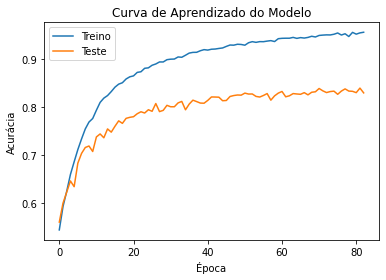

Salvando o modelo treinado...
Modelo salvo como 'model_redeht.h5'


In [108]:
print("Iniciando a construção do modelo...")
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# Compilando o modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'Recall'])

# Configurando o Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=50)

# Treinando o modelo
print("Treinando o modelo...")
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# Fazendo as predições
print("Fazendo predições no conjunto de teste...")
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

# Avaliando a acurácia do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

# Salvando o modelo
print("Salvando o modelo treinado...")
model.save('../models/model_redeht.h5')
print("Modelo salvo como 'model_redeht.h5'")

## Treinamento e Avaliação de Modelo Generativo GAN

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Definindo a dimensão do espaço latente
z_dim = X_train.shape[1]

# Criação do modelo do Gerador
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim, activation='relu'))
    model.add(Dense(X_train.shape[1], activation='linear'))
    return model

# Criação do modelo do Discriminador
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Construindo e compilando o Discriminador
discriminator = build_discriminator(X_train.shape[1])
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Construindo o Gerador
generator = build_generator(z_dim)

# Construindo e compilando a GAN
discriminator.trainable = False
gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=Adam())

print("Dimensão do espaço latente:", z_dim)
# print("Dimensão dos dados reais:", data_dim)
print('X_train shape:', X_train.shape)


Dimensão do espaço latente: 65
X_train shape: (25921, 65)


In [16]:
# Treinamento da GAN
losses = []
batch_size = 64
for epoch in range(10000):
    # Treinando o Discriminador
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_data = generator.predict(z)

    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train[idx]

    x = np.concatenate([real_data, gen_data])
    y = np.zeros(2 * batch_size)
    y[:batch_size] = 1

    d_loss = discriminator.train_on_batch(x, y)
    print(f"Epoch {epoch}: Discriminator Loss: {d_loss}")

    # Treinando o Gerador
    z = np.random.normal(0, 1, (batch_size, z_dim))
    y = np.ones(batch_size)
    g_loss = gan.train_on_batch(z, y)
    print(f"Epoch {epoch}: Generator Loss: {g_loss}")

    if epoch % 1000 == 0:
        losses.append((d_loss, g_loss))

# Salvando a GAN
gan.save('../models/gan_model.h5')
print("GAN model saved to '../models/gan_model.h5'")

2/2 [==============================] - 0s 5ms/step
Epoch 0: Discriminator Loss: [0.7139016389846802, 0.578125]
Epoch 0: Generator Loss: 0.8593116998672485
2/2 [==============================] - 0s 0s/step
Epoch 1: Discriminator Loss: [0.6713680028915405, 0.578125]
Epoch 1: Generator Loss: 0.8251428604125977
2/2 [==============================] - 0s 10ms/step
Epoch 2: Discriminator Loss: [0.7109116911888123, 0.515625]
Epoch 2: Generator Loss: 0.7402408123016357
2/2 [==============================] - 0s 2ms/step
Epoch 3: Discriminator Loss: [0.7146021723747253, 0.4921875]
Epoch 3: Generator Loss: 0.7252939939498901
2/2 [==============================] - 0s 11ms/step
Epoch 4: Discriminator Loss: [0.7407937049865723, 0.4609375]
Epoch 4: Generator Loss: 0.7306107878684998
2/2 [==============================] - 0s 2ms/step
Epoch 5: Discriminator Loss: [0.7811845541000366, 0.375]
Epoch 5: Generator Loss: 0.6866769194602966
2/2 [==============================] - 0s 2ms/step
Epoch 6: Discrimina

In [22]:
from sklearn.metrics import accuracy_score
# avaliando o modelo
pred = gan.predict(X_test)
pred = np.where(pred > 0.5, 1, 0)
gan_acc = accuracy_score(y_test, pred)
print("Acurácia do modelo GAN:", gan_acc)


203/203 [==============================] - 0s 866us/step
Acurácia do modelo GAN: 0.5085634932880728


In [27]:
gan.predict(preprocessor.transform((pd.DataFrame(df[df['result'] == 0].iloc[0])).T.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])))

1/1 [==============================] - 0s 19ms/step


array([[0.52977645]], dtype=float32)

In [19]:
# df.to_csv('data_final.csv', index=False, encoding='utf-8')

In [24]:
# Função para gerar dados sintéticos
def generate_data(generator, z_dim, num_samples):
    z = np.random.normal(0, 1, (num_samples, z_dim))
    generated_data = generator.predict(z)
    return generated_data

# Gerando dados sintéticos
num_samples_to_generate = X_test.shape[0]  # Defina quantos dados sintéticos você quer gerar
synthetic_data = generate_data(generator, z_dim, num_samples_to_generate)

# Convertendo para DataFrame para facilitar a manipulação e visualização
synthetic_df = pd.DataFrame(synthetic_data, columns=[f'feature_{i}' for i in range(synthetic_data.shape[1])])
real_data = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(real_data.shape[1])])

# Exibindo os primeiros registros dos dados gerados
print("Dados Sintéticos Gerados:")
print(synthetic_df.head())

  1/203 [..............................] - ETA: 5s

203/203 [==============================] - 0s 957us/step
Dados Sintéticos Gerados:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -1.695272  -0.969906  -0.877662  -0.073012  -0.123999  -1.222578   
1  -1.114839  -0.254965  -0.802345  -0.072814  -0.121794  -0.504921   
2  -0.712233  -0.582572   0.376316  -0.117659  -0.100883  -0.802689   
3   1.200573   1.451446   1.495198  -0.132965  -0.159214   1.864154   
4   0.002448   1.140336  -0.724714  -0.097549  -0.215355   0.904599   

   feature_6  feature_7  feature_8  feature_9  ...  feature_55  feature_56  \
0  -1.067191  -0.737647  -0.580096  -0.434993  ...    0.023777   -0.027858   
1  -0.849801  -0.643915  -0.538081  -0.403302  ...    0.010806   -0.039125   
2   0.178664  -0.650197  -0.349716  -0.399832  ...   -0.036548   -0.032530   
3  -0.332936  -0.705613  -0.021734  -0.199509  ...   -0.024650   -0.122535   
4  -0.472041  -0.669006  -0.323699  -0.300423  ...   -0.005279   -0.108469   

   feature_57  featur

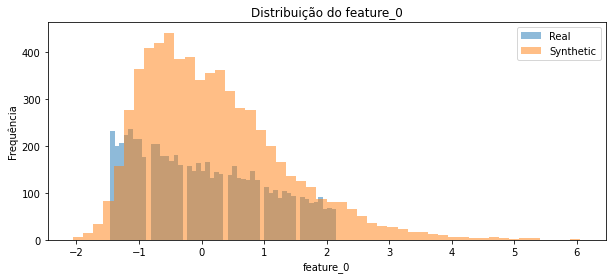

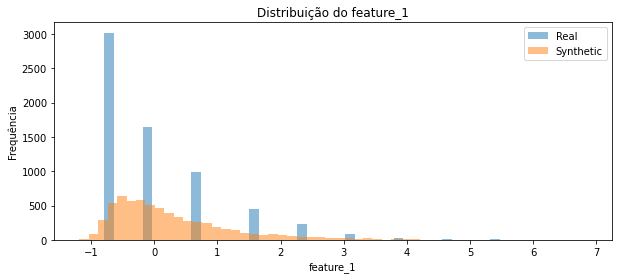

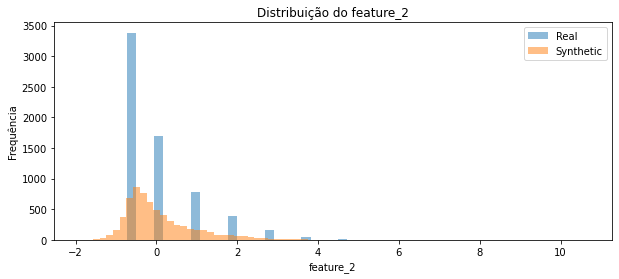

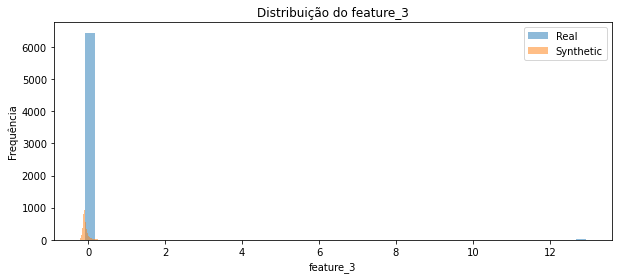

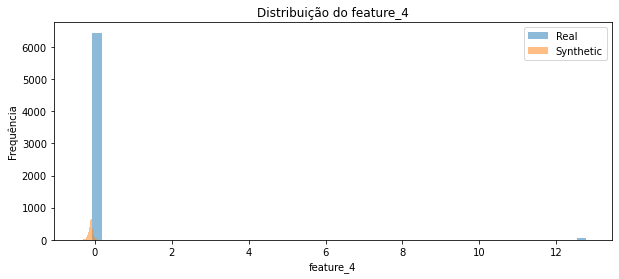

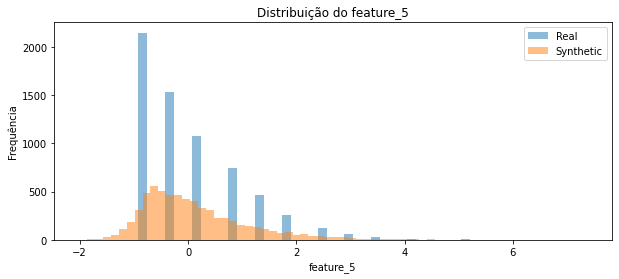

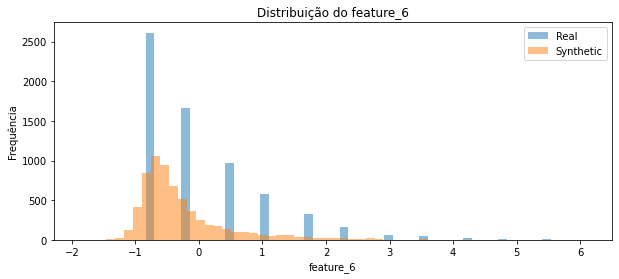

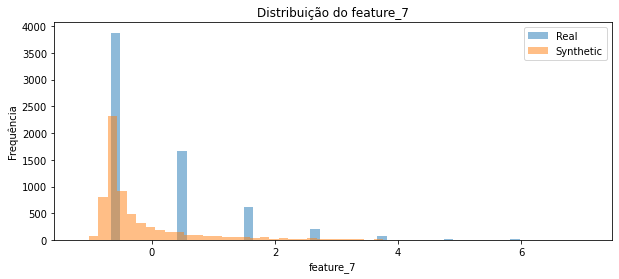

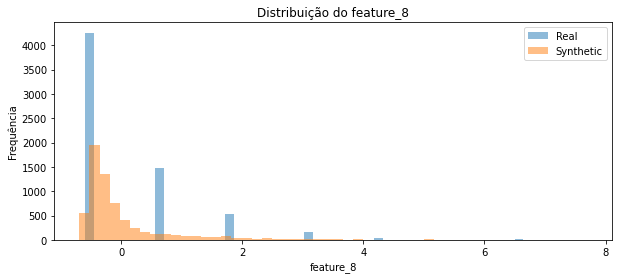

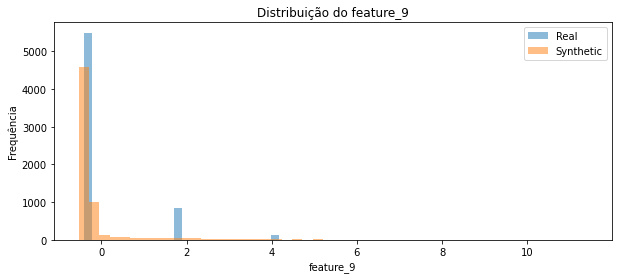

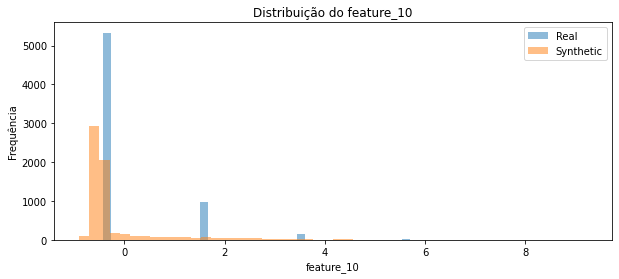

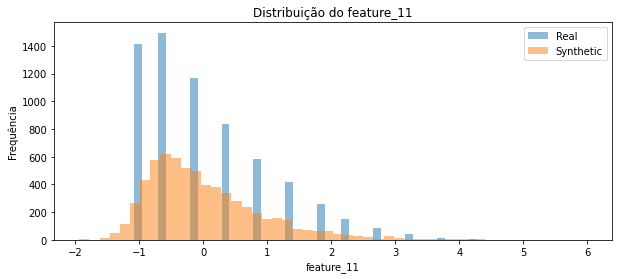

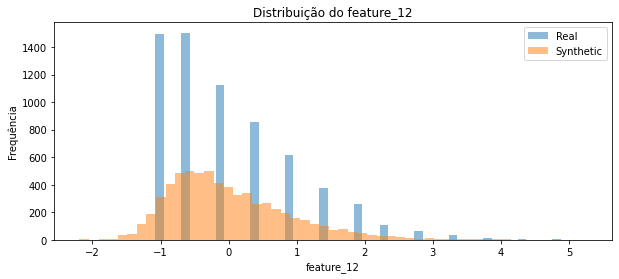

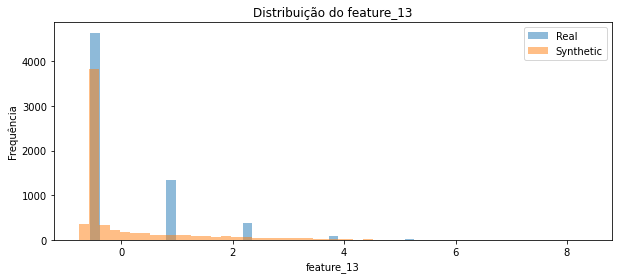

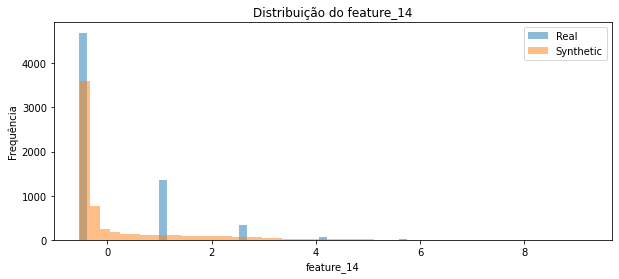

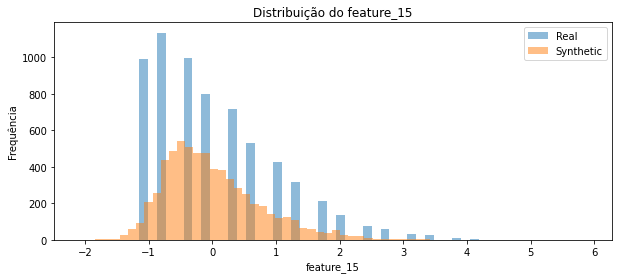

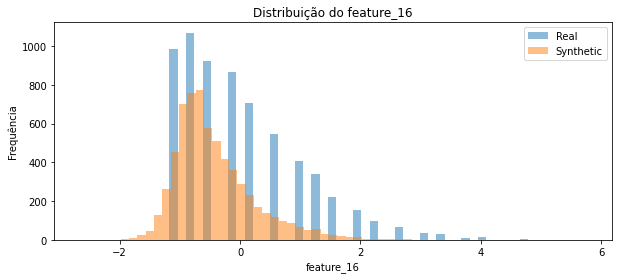

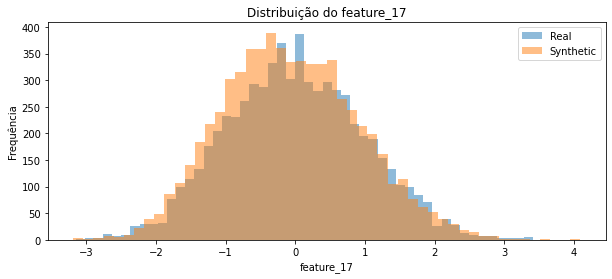

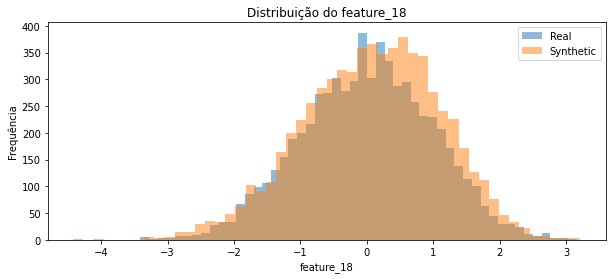

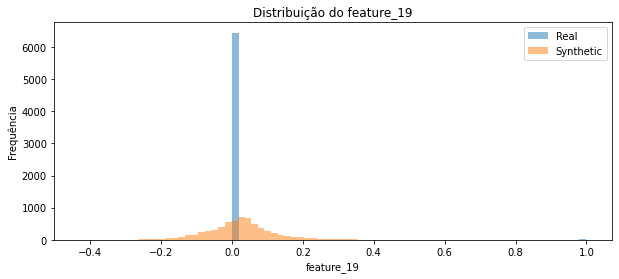

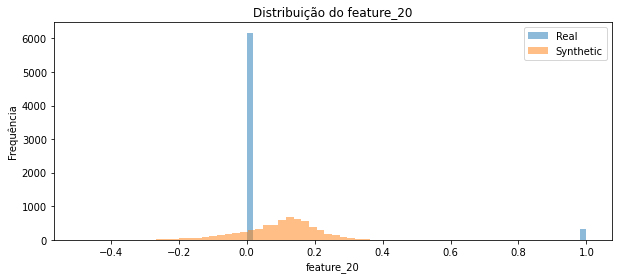

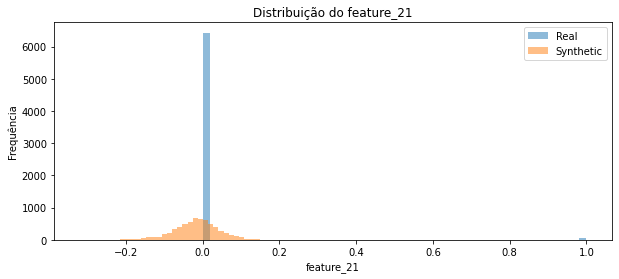

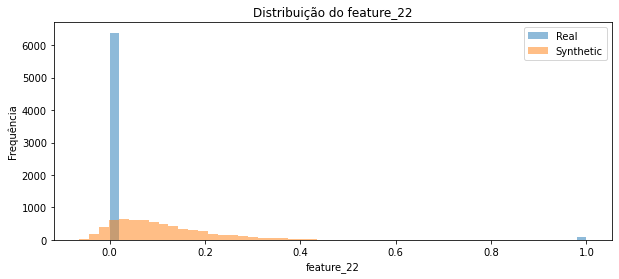

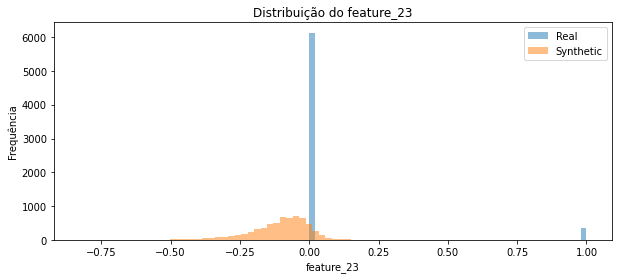

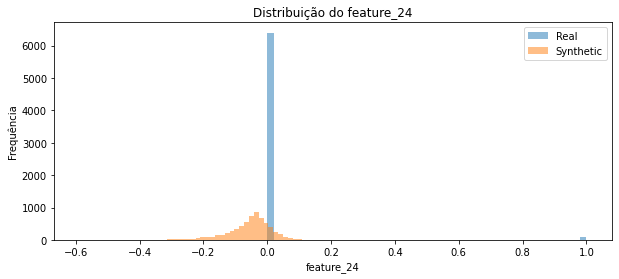

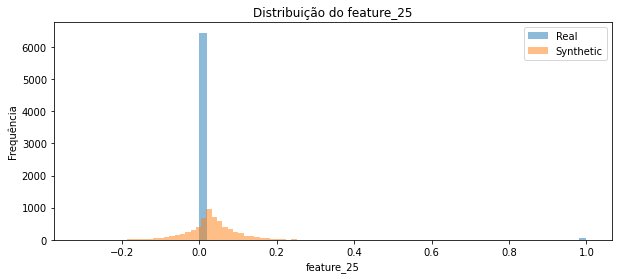

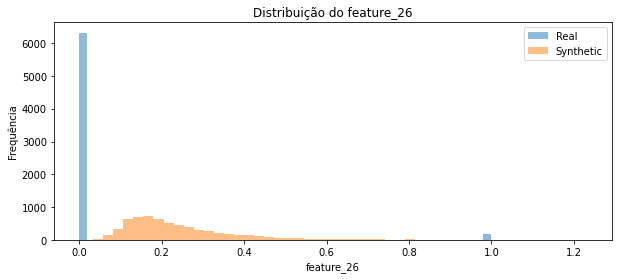

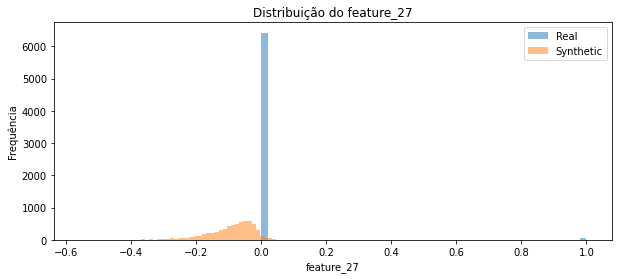

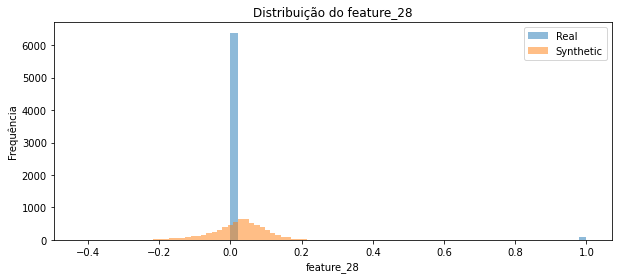

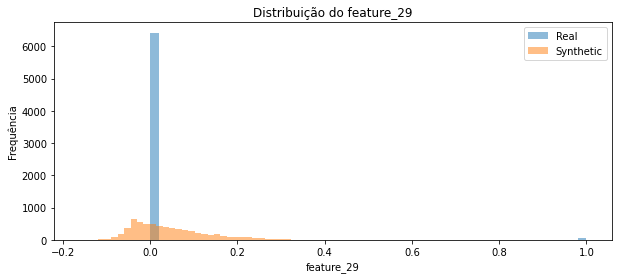

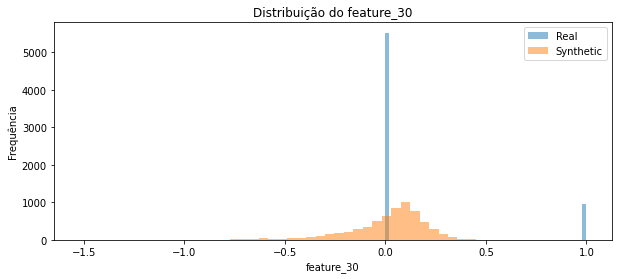

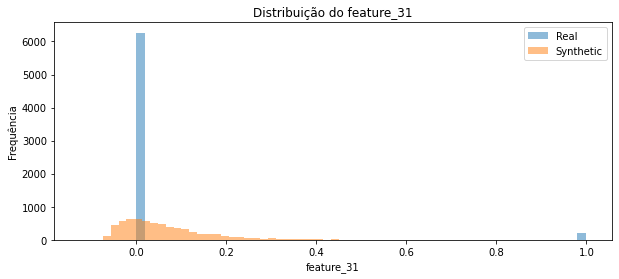

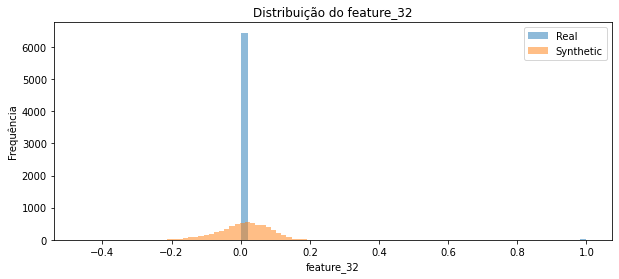

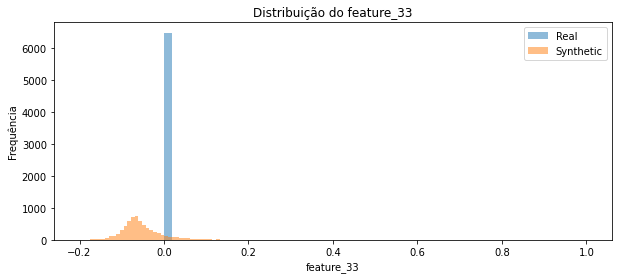

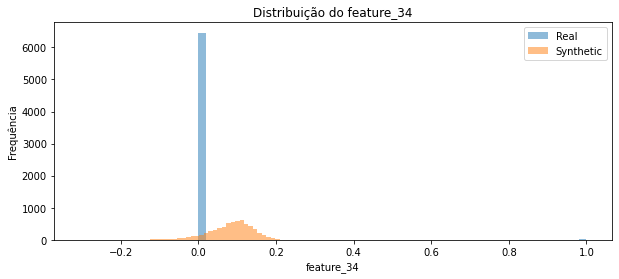

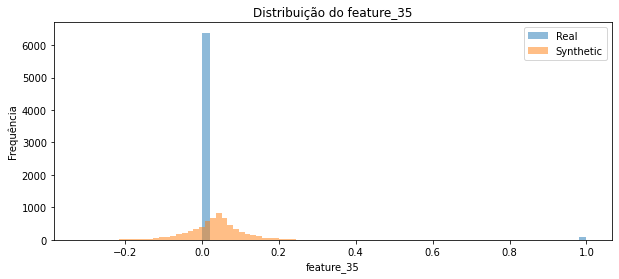

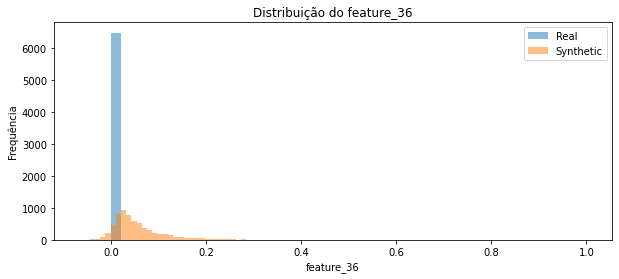

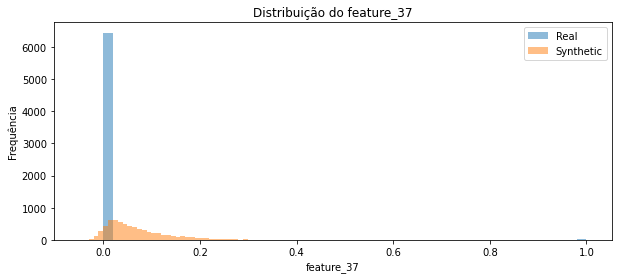

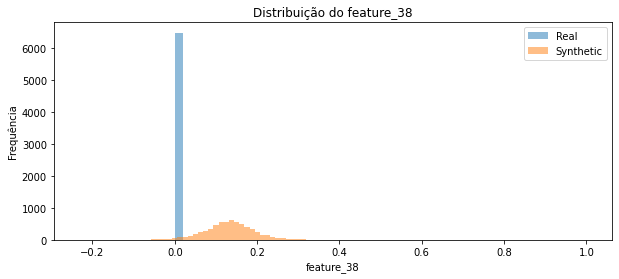

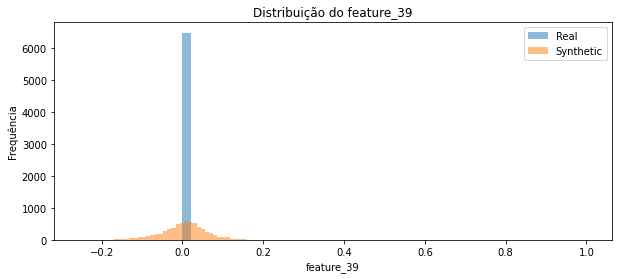

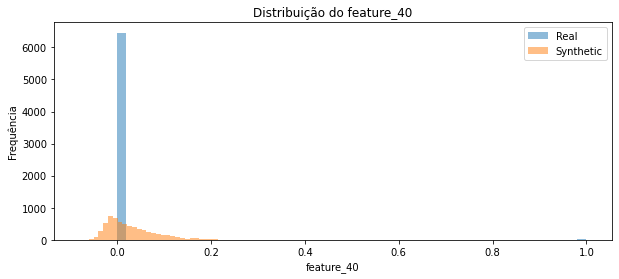

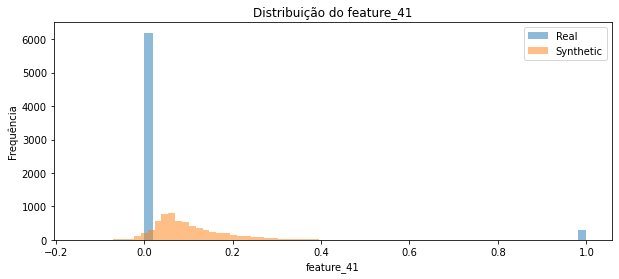

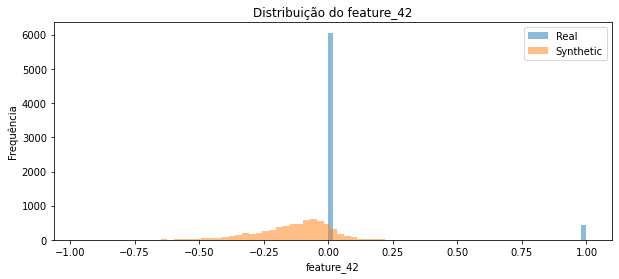

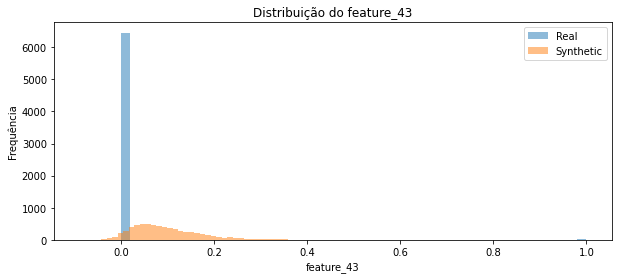

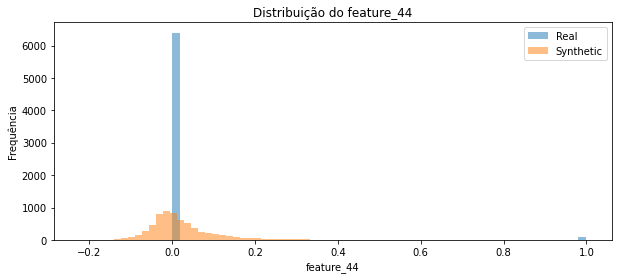

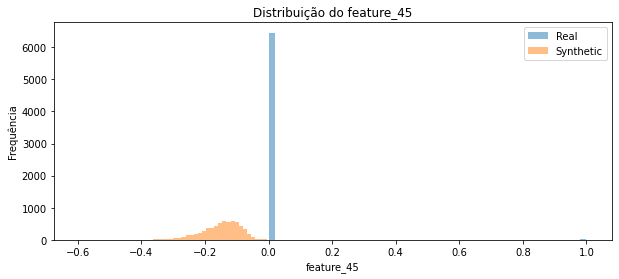

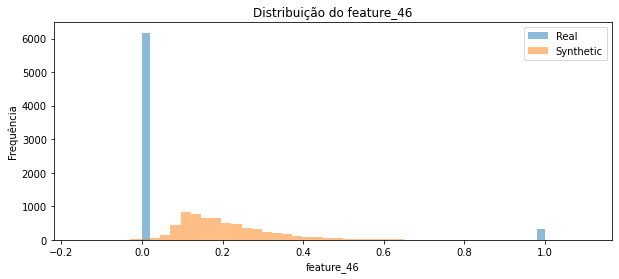

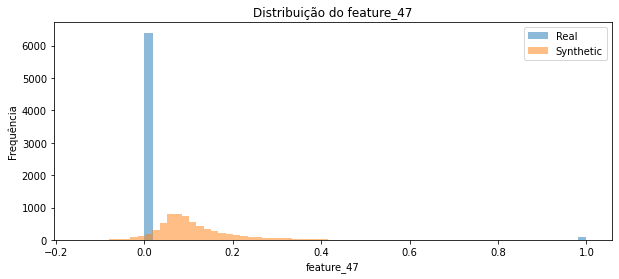

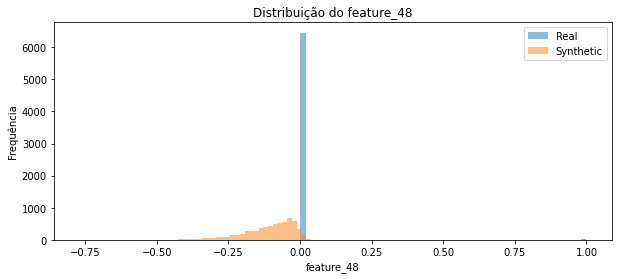

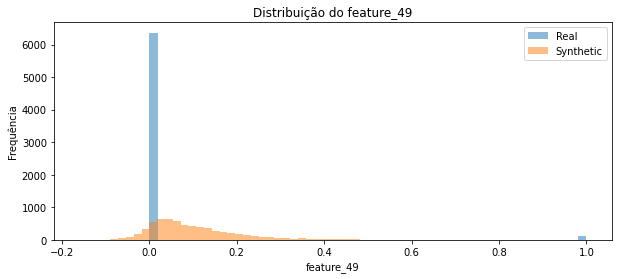

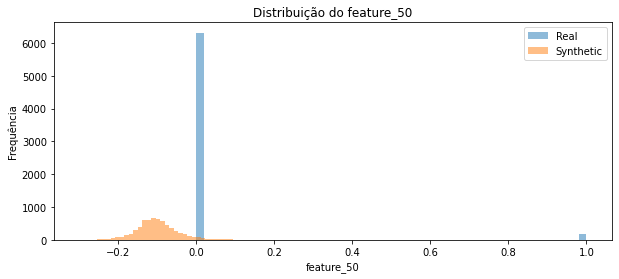

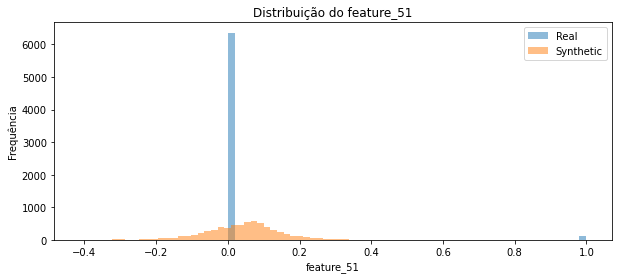

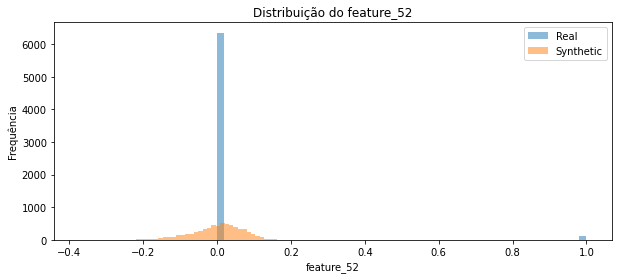

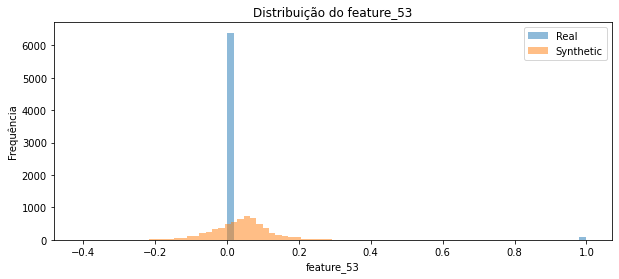

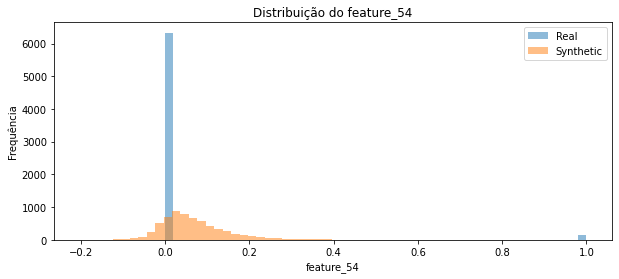

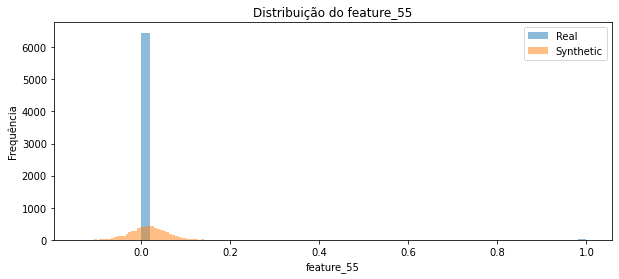

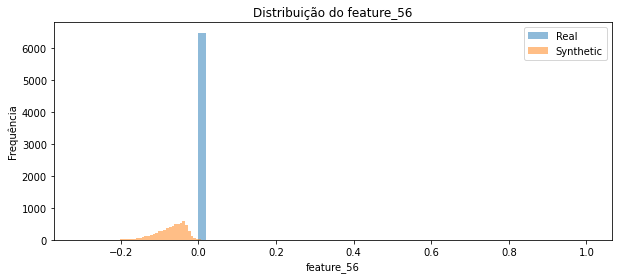

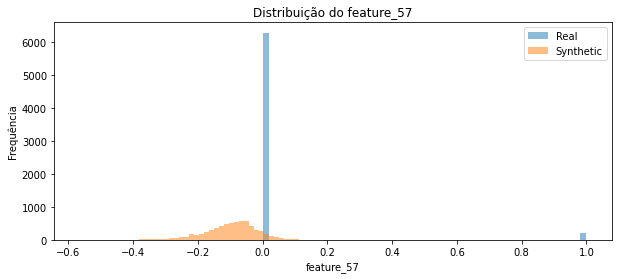

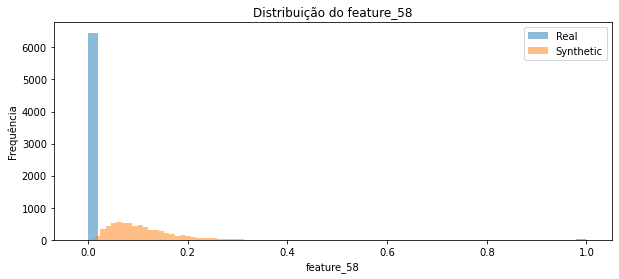

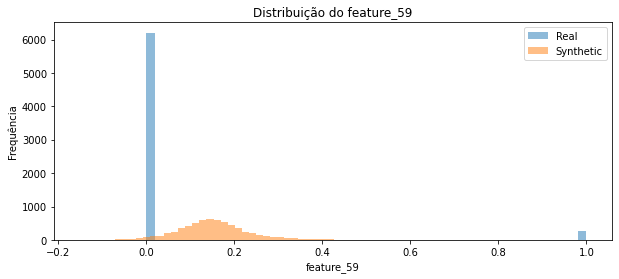

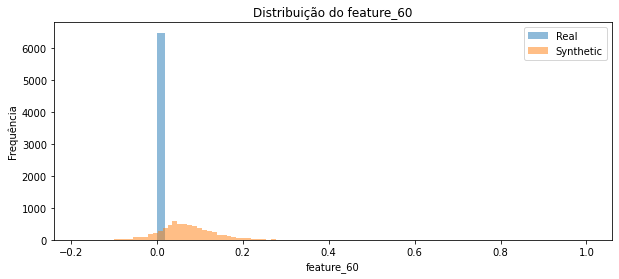

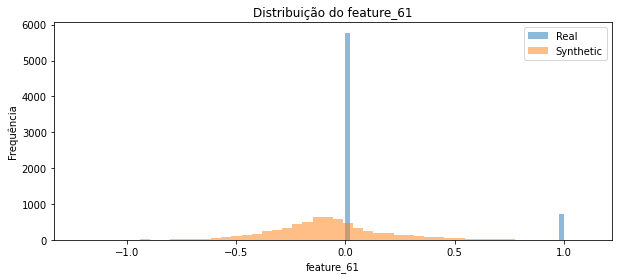

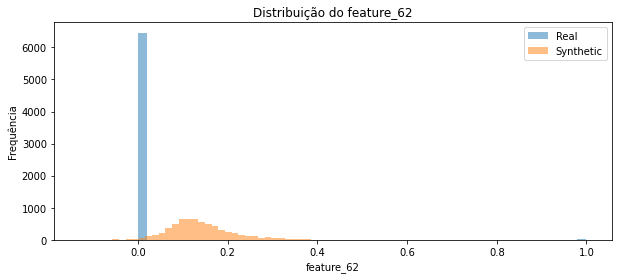

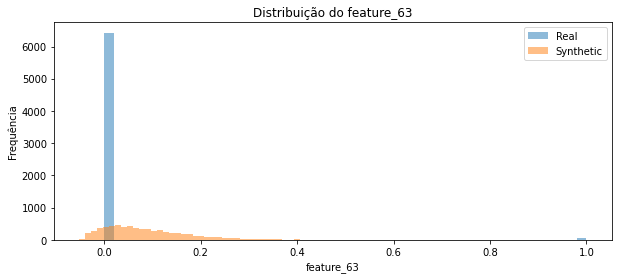

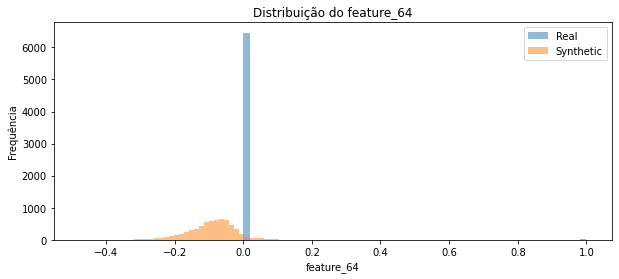

In [25]:
# Avaliação dos dados gerados
# Aqui, você pode adicionar seu próprio código para avaliar os dados gerados.
# Isso pode incluir comparações com os dados reais, verificações de distribuições, etc.
# Por exemplo:

# Comparando distribuições de recursos com dados reais
# (Supondo que você tenha um DataFrame chamado 'real_data_df' com os dados reais)
for column in synthetic_df.columns:
    plt.figure(figsize=(10, 4))
    plt.hist(real_data[column], bins=50, alpha=0.5, label="Real")
    plt.hist(synthetic_df[column], bins=50, alpha=0.5, label="Synthetic")
    plt.title(f"Distribuição do {column}")
    plt.xlabel(column)
    plt.ylabel("Frequência")
    plt.legend()
    plt.show()
